In [2]:
# imports
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib
%matplotlib inline
import pylab as pl

# Introduction

# Simple transcription-translation system modeled by a deterministic ODE system

## Biochemical reactions

In a simple transcription-translation system the RNA of a certain gene is prodcued with a fixed rate $\beta$ and decays with a rate proportional to the curren amount of RNA, a so called first order decay. The protein that our gene is coding for is produced with a rate that is proportional to the current amount of RNA and follows a first order decay as well. A reaction scheme of this small system looks like this:

$$\xrightarrow{\beta} RNA \xrightarrow{\gamma_{m}} o$$ $$RNA \xrightarrow{k} protein$$ $$protein \xrightarrow{\gamma_{p}} o$$

## Deterministic ODE system

The above reaction scheme can be tranlated into two [differential equations](https://en.wikipedia.org/wiki/Differential_equation). For the sake of simplicity we have assumed [mass action kinetics](https://en.wikipedia.org/wiki/Law_of_mass_action) without any saturation effects.

$$ \dot{RNA} = \beta - \gamma_{m}\cdot RNA$$ 

$$ \dot{protein} = k\cdot RNA - \gamma_{p} \cdot protein$$

This system of equations describes the rule how the systems state given by the concentration of RNA and protein molecules changes given the current state. The left hand side of the equations are the rate of change and the right hand side the rule how the change depends on the current state. Note that the concentration of RNA appears in both equations, thus the equations are coupled as the amount of proteins depends on the amount of RNA.

To explicitly solve ODEs it is necessary to know the state of the system at one instant of time. Often reffered to as the intial conditions and associated with time point $t = 0$. 

## Analytic solution

The general solution of the ODE system is given by:
$$ \text{RNA}(t)= \frac{b}{\gamma_{m}}+c_1 e^{-\gamma_{m} t}$$

$$\text{protein}(t)= \frac{b\cdot k}{\gamma_{m} \gamma_{p}}+\frac{e^{-(\gamma_{m}+\gamma_{p})t} \left(e^{\gamma_{m} t} \left(c_{2} (\gamma_{m}-\gamma_{p})+c_1 k\right)-c_{1} k e^{\gamma_{p} t}\right)}{\gamma_{m}-\gamma_{p}}$$

The constants $c_{1}$ and $c_{2}$ can be determined using the intitial conditions.

For the simple ODE system given here it is possible to obtain a analytical solution, in more complex situations this usually is not possible and it is necessary to numerically integrate differential equations. Although we could work here with the analytical solutions we want to go the numerical way. A first impression on how an algorithm could approximate a solution of an ODE gives [Euler method](https://en.wikipedia.org/wiki/Euler_method).

In [3]:
# functions
def solve_ODE_transcription_translation(x,t,param):
    RNA = x[0]
    protein = x[1]
    
    dRNA = param[0] - param[1]*RNA
    dprotein = param[2]*RNA - param[3]*protein
    
    return np.hstack((dRNA,dprotein))

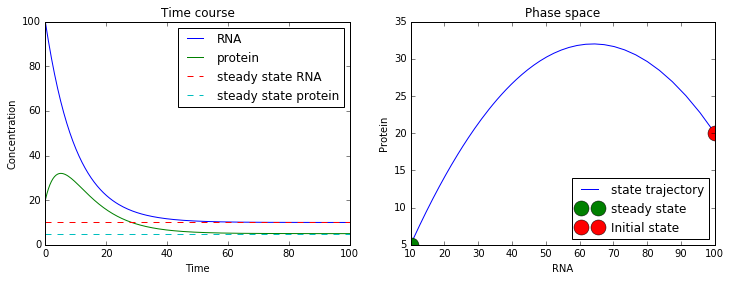

In [47]:
# define parameters and time vector to solve the ODEs
beta = 1
gamma_m = 0.1
k = 0.1
gamma_p = 0.2
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 100
protein_0 = 20
y_0 = [RNA_0,protein_0]

# set the time vector
tt = sp.linspace(0,100,200)

# solve the ODE system with the defined parameters and initial condition
sol = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

# plot the result
fig,ax = pl.subplots(1,2, figsize = (12,4))
ax[0].plot(tt,sol[:,0], label = 'RNA')
ax[0].plot(tt,sol[:,1], label = 'protein')
ax[0].plot(tt,np.zeros(len(tt)) + steady_state_RNA,'--', label = 'steady state RNA')
ax[0].plot(tt,np.zeros(len(tt)) + steady_state_protein,'--', label = 'steady state protein')
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[0].set_title('Time course')

ax[1].plot(sol[:,0],sol[:,1], label = 'state trajectory')
ax[1].plot(steady_state_RNA,steady_state_protein,'o',ms = 15,label = 'steady state')
ax[1].plot(RNA_0,protein_0,'o',ms = 15,label = 'Initial state')
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')

# Transcription-translation system modeled as stochastic system: single cell behaviour

## The stochastic simulation algorithm

Developed mainly by Daniel Gillespie. The algorithm simulates the stochastic biochemical interactions of the reacting species, here RNA and protein, based on the current amount molecules of each species and the rates of the possible reactions. The algorithm essentially is a loop and in each iteration the next reaction that happens and the time point of the reaction are simulated based on random number generation. A deeper explanation of the algorithm can be found on [wikipedia](https://en.wikipedia.org/wiki/Gillespie_algorithm) or in the original publications of [D. Gillespie](http://pubs.acs.org/doi/abs/10.1021/j100540a008). [Here](https://www.ncbi.nlm.nih.gov/pubmed/17037977) you can find a comprehensible review of the algorithm, it's foundations and possible approximate implementations.

In contrast to the deterministic ODE system above the amount of RNA and protein now is not measured in concentrations but in the number of molecules of each species. The systems state is defined by the set of molecule counts. During each iteration of the algorithm the systems state is update according to the sampled reaction.

The system consists of four different reactions:

1. **RNA production:** $ RNA \xrightarrow{\beta} RNA + 1$
2. **RNA decay:** $RNA \xrightarrow{\gamma_{m}\cdot RNA} RNA - 1$
3. **Protein production:** $protein \xrightarrow{k\cdot RNA} protein + 1$
4. **Protein decay:** $protein \xrightarrow{\gamma_{p}\cdot protein} protein - 1$

The likelihood of each reaction depends of the current state of the system, i.e. the number of present RNA and protein molecules.

In [22]:
def stoch_sim_transcription_translation(param,initial_state,tf):
    beta,gamma_m,k,gamma_p = param[0],param[1],param[2],param[3]
    
    # reaction matrix, the systems state includes the time points of the reactions in the first column
    reactions = np.array([[0,1,0],
                         [0,-1,0],
                         [0,0,1],
                         [0,0,-1]])
    
    state = np.zeros(3)
    state[1] = initial_state[0]
    state[2] = initial_state[1]
    STATE = state
    
    tt = 0
    while tt <= tf:
        # sample two random numbers uniformly between 0 and 1
        rr = sp.random.uniform(0,1,2)
        
        a_0 = beta + gamma_m*state[1] + k*state[1] + gamma_p*state[2]
        a_s = np.array([beta,gamma_m*state[1],k*state[1],gamma_p*state[2]],dtype = float)
        
        # time step 
        tt = tt + 1. / a_0 * sp.log(1. / rr[0])
        state[0] = tt
        
        # find the next reaction
        prop = rr[1] * a_0
        cum_a_s = np.cumsum(a_s)
        
        ind = np.where(prop <= cum_a_s)[0][0]
        state = state+reactions[ind]
        
        STATE = np.vstack((STATE,state))
    
    return STATE

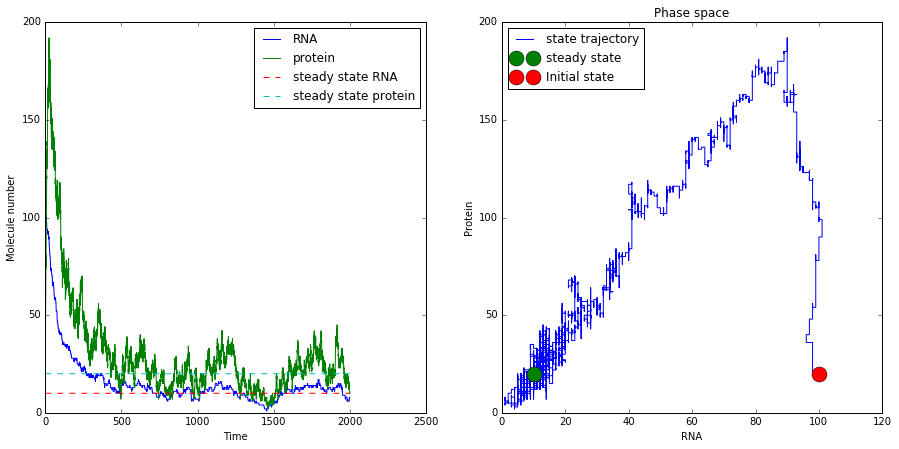

In [46]:
# define parameters and time vector to solve the ODEs
beta = 0.1
gamma_m = 0.01
k = 0.2
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 100
protein_0 = 20
initial_state = [RNA_0,protein_0]

# simulation time
tf = 2000

sim = stoch_sim_transcription_translation(param,initial_state,tf)

fig,ax = pl.subplots(1,2, figsize = (15,7))
ax[0].plot(sim[:,0],sim[:,1], label = 'RNA')
ax[0].plot(sim[:,0],sim[:,2], label = 'protein')
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_RNA,'--', label = 'steady state RNA')
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_protein,'--', label = 'steady state protein')
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Molecule number')

ax[1].plot(sim[:,1],sim[:,2], label = 'state trajectory')
ax[1].plot(steady_state_RNA,steady_state_protein,'o',ms = 15,label = 'steady state')
ax[1].plot(RNA_0,protein_0,'o',ms = 15,label = 'Initial state')
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')